In [93]:
%matplotlib inline
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt


tokens = ['A', 'B', 'C']
token_index = {token: i for i, token in enumerate(tokens)}

class OutOfBoundsError(Exception):
    pass

class AMM:
    def __init__(self, initial_reserve: np.array):
        # self.utility_fn = utility_fn
        self._reserve: np.array = initial_reserve
        self.active = True
    
    def gradients(self):
        raise NotImplementedError()
    
    def trade(self, amounts):
        u1 = self.utility
        self._reserve += amounts
        u2 = self.utility
        if u2 < u1: 
            self._reserve -= amounts
            raise ValueError(f"Utility decreased from {u1} to {u2} after trade")
        if any(self._reserve < 0):
            self._reserve -= amounts
            raise ValueError("Reserves cannot be negative")
        return self._reserve
    
    @property
    def reserve(self):
        return self._reserve.copy()
    
    # price of out_token in terms of in_token
    def price(self, out_token, in_token):
        gradients = self.gradients()
        in_grad, out_grad = gradients[token_index[in_token]], gradients[token_index[out_token]]
        return out_grad / in_grad

    @property  
    def utility(self):
        raise NotImplementedError()
    
    def gradients(self):
        # numerically differentiate the utility function to get the gradients
        grads = optimize.approx_fprime(self._reserve, self.utility, 1e-4)
        normalized_grads = grads / np.mean(grads) # TODO maybe change this to geometric mean
        assert all(normalized_grads >= 0), "Gradients must be positive. No token should decrease utility"
        assert len(normalized_grads) == len(self._reserve), "Gradients must have the same length as the reserve"
        return normalized_grads
    
    def plot_vals(self, token1, token2, one_vals):
        raise NotImplementedError()
    
    def plot(self, token1, token2, one_min=0.01, one_max=100, n=100, label=None, color="red"):
        one_vals = np.linspace(one_min, one_max, n)
        two_vals = self.plot_vals(token1, token2, one_vals)
        plt.xlabel(f"token {token1}")
        plt.ylabel(f"token {token2}")
        plt.title(f"Reserve curve of {token1} and {token2}")
        plt.plot(one_vals, two_vals, label=label)
        plt.scatter(self._reserve[token_index[token1]], self._reserve[token_index[token2]], color=color) 
        plt.ylim(0, one_max)
        plt.xlim(0, one_max)

    def plot_vals_3d(self, token1, token2, token3, one_vals, two_vals):
        raise NotImplementedError()

    def plot3d(self, token1, token2, token3, min_val=0.01, max_val=100, n=100, label=None, ax=None):
        one_vals = np.linspace(min_val, max_val, n)
        two_vals = np.linspace(min_val, max_val, n)
        one_mesh, two_mesh = np.meshgrid(one_vals, two_vals)
        three_mesh = self.plot_vals_3d(token1, token2, token3, one_mesh, two_mesh)
        fig = plt.figure()
        if not ax:
            print("making new axis")
            ax = fig.add_subplot(111, projection='3d')

        # Plotting the surface
        ax.plot_surface(one_mesh, two_mesh, three_mesh, cmap='viridis')    
        ax.scatter(self._reserve[token_index[token1]], self._reserve[token_index[token2]], self._reserve[token_index[token3]], color='red') 
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_zlim(0, max_val)
        ax.set_xlabel(f"token {token1}")
        ax.set_ylabel(f"token {token2}")
        ax.set_zlabel(f"token {token3}")
        plt.title(f"Reserve curve of {token1}, {token2} and {token3}")
        plt.show()
        return ax

    
class ConstantSumAMM(AMM):
    def __init__(self, initial_reserve, prices):
        super().__init__(initial_reserve)
        self.prices = prices
    
    def gradients(self):
        return self.prices
    
    def price(self, out_token, in_token):
        return self.prices[token_index[out_token]] / self.prices[token_index[in_token]]
    
    @property
    def utility(self):
        return np.dot(self.prices, self._reserve)
    
    @staticmethod
    def from_prices(prices, constant_sum):
        initial_reserve = np.array([constant_sum / price if price else 0 for price in prices])
        # print(initial_reserve)
        # make sum of reserves equal to constant_sum
        initial_reserve = initial_reserve / np.dot(prices, initial_reserve) * constant_sum
        # print(initial_reserve)
        return ConstantSumAMM(initial_reserve, prices)
    
    def plot_vals_3d(self, token1, token2, token3, one_mesh, two_mesh):
        utility = 0
        for token in [token1, token2, token3]:
            utility += self._reserve[token_index[token]] * self.prices[token_index[token]]
        one_vals = one_mesh
        two_vals = two_mesh
        three_vals = (utility - one_vals * self.prices[token_index[token1]] - two_vals * self.prices[token_index[token2]]) / self.prices[token_index[token3]]
        return three_vals

        
    
    def plot_vals(self, token1, token2, one_vals):
        # plot the curve of the sum of the reserves, along the invariant of start_utility
        utility = self._reserve[token_index[token1]] * self.prices[token_index[token1]] + self._reserve[token_index[token2]] * self.prices[token_index[token2]]
        two_tokens = (utility - one_vals * self.prices[token_index[token1]]) / self.prices[token_index[token2]]
        return two_tokens
    
class ConstantProductAMM(AMM):
    def __init__(self, initial_reserve, exponents=None):
        super().__init__(initial_reserve)
        if not exponents:
            exponents = np.zeros_like(initial_reserve)
            exponents[initial_reserve != 0] = 1
        self.exponents = exponents
    
    def gradients(self):
        # the gradient of the product of the reserves is the product of the reserves divided by each reserve
        total_utility = self.utility
        grads = np.zeros_like(self._reserve)
        # print(total_utility)
        # print(total_utility / self._reserve)
        grads = total_utility / self._reserve
        return grads
    
    @property
    def utility(self):
        return np.prod(np.power(self._reserve, self.exponents))
    
    @staticmethod
    def from_prices(prices, constant_product, exponents=None):
        if not exponents:
            exponents = np.zeros_like(prices)
            exponents[prices != 0] = 1

        # find stable reserves if constant product is np.prod(np.power(initial_reserve, exponents))
        # make sure to use exponents
        initial_reserve = np.array([(constant_product / price)**exp if price else 0 for price, exp in zip(prices, exponents)])
        # print(initial_reserve)
        # print(constant_product / np.prod(np.power(initial_reserve, exponents)))
        # print((constant_product / np.prod(np.power(initial_reserve, exponents))) ** (1/sum(np.array(prices) != 0)))
        # make product of reserves equal to constant_product
        initial_reserve =  (constant_product / np.prod(np.power(initial_reserve, exponents))) ** (1/sum(np.array(prices) != 0)) * initial_reserve
        # print(initial_reserve)
        return ConstantProductAMM(initial_reserve)
    
    def plot_vals(self, token1, token2, one_vals):
        utility = self._reserve[token_index[token1]] ** self.exponents[token_index[token1]] * self._reserve[token_index[token2]] ** self.exponents[token_index[token2]]
        one_vals_with_power = one_vals ** self.exponents[token_index[token1]]
        two_vals = (utility / one_vals_with_power) ** (1 / self.exponents[token_index[token2]])
        return two_vals
    
    def plot_vals_3d(self, token1, token2, token3, one_vals, two_vals):
        utility = self._reserve[token_index[token1]] ** self.exponents[token_index[token1]] * self._reserve[token_index[token2]] ** self.exponents[token_index[token2]] * self._reserve[token_index[token3]] ** self.exponents[token_index[token3]]
        one_vals_with_power = one_vals ** self.exponents[token_index[token1]]
        two_vals_with_power = two_vals ** self.exponents[token_index[token2]]
        three_vals = (utility / (one_vals_with_power * two_vals_with_power)) ** (1 / self.exponents[token_index[token3]])
        return three_vals
    
    
class HomotropyAMM(AMM):
    def __init__(self, initial_reserve, prices, t):
        super().__init__(initial_reserve)
        assert 0 <= t <= 1, "t must be between 0 and 1"
        self.initial_reserve = np.array(initial_reserve)
        self.t = t
        self.prices = np.array(prices)

    def gradients(self):
        csamm_part = self.prices / np.sum(self.prices * self.initial_reserve)
        cpmm_part = np.prod(self.initial_reserve) / np.prod(self._reserve) / self._reserve
        return (csamm_part * (1 - self.t)) + (cpmm_part * self.t)
    
    @property
    def utility(self):
        csamm_part = np.sum(self.prices * self.initial_reserve) / np.sum(self.prices * self._reserve)
        cpamm_part = np.prod(self.initial_reserve) / np.prod(self._reserve)
        return (csamm_part * (1 - self.t)) + (cpamm_part * self.t)
    
    @staticmethod
    def from_prices(prices, t, constant_sum):
        raise NotImplementedError()
    
    def plot_vals(self, token1, token2, one_vals):
        utility_csamm_numerator = self.prices[token_index[token1]] * self.initial_reserve[token_index[token1]] + self.prices[token_index[token2]] * self.initial_reserve[token_index[token2]]
        utility_csamm_denominator = self.prices[token_index[token1]] * self._reserve[token_index[token1]] + self.prices[token_index[token2]] * self._reserve[token_index[token2]]
        utility_csamm = utility_csamm_denominator / utility_csamm_numerator

        utility_cpmm_numerator = self.initial_reserve[token_index[token1]] * self.initial_reserve[token_index[token2]]
        utility_cpmm_denominator = self._reserve[token_index[token1]] * self._reserve[token_index[token2]]
        utility_cpmm = utility_cpmm_denominator / utility_cpmm_numerator

        utility = utility_csamm * (1 - self.t) + utility_cpmm * self.t

        # TODO solve for two_vals
        pass



        
def rebalance_step(amm1, amm2, alpha):
    u1, u2 = amm1.utility, amm2.utility
    # print(f"utilities before trade: {u1}, {u2}")
    # find the gradient of the utility function
    grad1, grad2 = amm1.gradients(), amm2.gradients()
    # normalize the gradients
    grad1, grad2 = grad1 / np.mean(grad1), grad2 / np.mean(grad2)
    # find update step
    delta = (grad1 - grad2) / ((grad1 + grad2) / 2)
    amm1.trade(delta * alpha)
    amm2.trade(-delta * alpha)
    du1, du2 = amm1.utility - u1, amm2.utility - u2
    # print(f"utilities after trade: {amm1.utility}, {amm2.utility}. Deltas: {du1}, {du2}")
    return [du1, du2]

def rebalance_step_n_amms(amms, alpha):
    u1 = np.array([amm.utility for amm in amms])
    grads = np.array([amm.gradients() for amm in amms])
    print("grads:")
    print(grads)
    # mean gradient per AMM (one value for each AMM)
    amm_sums = np.sum(grads, axis=1)
    print("amm_sums:")
    print(amm_sums)
    # correct each amm in the case where one AMM's utilities are much higher
    grads_normalized = grads / amm_sums[:, np.newaxis]
    print("grads_normalized:")
    print(grads_normalized)

    # each token's mean gradient
    sum_each_token = np.sum(grads_normalized, axis=0)
    # find the average exluding self, to be subtracted from the gradient to calculate the delta
    avg_excluding_self = (sum_each_token - grads_normalized) / (len(amms) - 1)
    # calculate deltas, divide to account for the importance of each token
    deltas = (grads_normalized - avg_excluding_self)
    deltas /= grads_normalized # This is to make the deltas smaller when the gradients are large
    print("deltas:")
    print(deltas)
    for amm, delta in zip(amms, deltas):
        try:
            amm.trade(alpha*delta)
        except OutOfBoundsError:
            pass
    u2 = np.array([amm.utility for amm in amms])
    return 0 # FIXME
    return u2 - u1

# print(reserves1)


In [94]:
def rebalance_n_amms(amms, epsilon, alpha, vis1="A", vis2="B", max_val=20):
    vis1_index, vis2_index = token_index[vis1], token_index[vis2]
    N = len(amms)
    print(f"reserves before: {', '.join(str(amm.reserve) for amm in amms)}")
    utilities = [amm.utility for amm in amms]
    print(f"utilities before: {', '.join(str(u) for u in utilities)}")
    gradient_sums = [np.sum(amm.gradients()) for amm in amms]
    ut_over_grad_sums_before = [u / g for u, g in zip(utilities, gradient_sums)]
    print(f"new metric before: {', '.join(str(u) for u in ut_over_grad_sums_before)}")



    reserves = []
    utility = []


    for i, amm in enumerate(amms):
        amm.plot(vis1, vis2, .1, max_val, 1000, f"amm{i}, before", "green")
    while True:
        reserves.append([amm.reserve for amm in amms])
        utility.append([amm.utility for amm in amms])
        try:
            # du1, du2 = rebalance_step(amm1, amm2, alpha)
            u_changes = rebalance_step_n_amms(amms, alpha)
        except ValueError as e:
            print(f"Exiting: {e}")
            # raise e
            break
        
        if all(u_changes < epsilon):
            break

    for i, amm in enumerate(amms):
        amm.plot(vis1, vis2, .1, max_val, 1000, f"amm{i}, after")

    reserves = np.array(reserves)
    utility = np.array(utility)
    for i in range(N):
        plt.plot(reserves[:, i, vis1_index], reserves[:, i, vis2_index], "--") # label=f"amm{i} price movement")
    plt.legend()
    WINDOW_OFFSET = 10 # set to -1 to disable
    if WINDOW_OFFSET != -1: 
        plt.xlim(max(min(np.concatenate(reserves[:, :, vis1_index])) - WINDOW_OFFSET, 0), max(np.concatenate(reserves[:, :, vis1_index])) + WINDOW_OFFSET)
        plt.ylim(max(min(np.concatenate(reserves[:, :, vis2_index])) - WINDOW_OFFSET, 0), max(np.concatenate(reserves[:, :, vis2_index])) + WINDOW_OFFSET)
    else:
        plt.xlim(left=0)
        plt.ylim(bottom=0)
    print(f"reserves after: {', '.join(str(amm.reserve) for amm in amms)}")
    after_utilities = [amm.utility for amm in amms]
    after_gradient_sums = [np.sum(amm.gradients()) for amm in amms]
    ut_over_grad_sums_after = [u / g for u, g in zip(after_utilities, after_gradient_sums)]
    print(f"utility after: {', '.join(str(u) for u in after_utilities)}")
    print(f"utility change: {', '.join(str(u) for u in np.array(after_utilities) - np.array(utilities))}")
    print(f"utility pct cg: {', '.join(str(u)+'%' for u in 100*(np.array(after_utilities) - np.array(utilities)) / np.array(utilities))}")
    print(f"new metrics after: {', '.join(str(u) for u in ut_over_grad_sums_after)}")
    benefit_ratio = np.array(ut_over_grad_sums_after) / np.array(ut_over_grad_sums_before)
    print(f"benefit ratio: {', '.join(str(u) for u in benefit_ratio)}")
    print(f"convergence in {reserves.shape[0]} steps")
    return reserves, utility


reserves: [10, 20], utility: 200, gradients: [20. 10.]
reserves: [60, 40], utility: 2400, gradients: [40. 60.]
reserves before: [10, 20], [60, 40]
utilities before: 200, 2400
new metric before: 6.666666666666667, 24.0
grads:
[[20. 10.]
 [40. 60.]]
amm_sums:
[ 30. 100.]
grads_normalized:
[[0.66666667 0.33333333]
 [0.4        0.6       ]]
deltas:
[[ 0.25       -0.28571429]
 [-0.25        0.28571429]]


TypeError: 'bool' object is not iterable

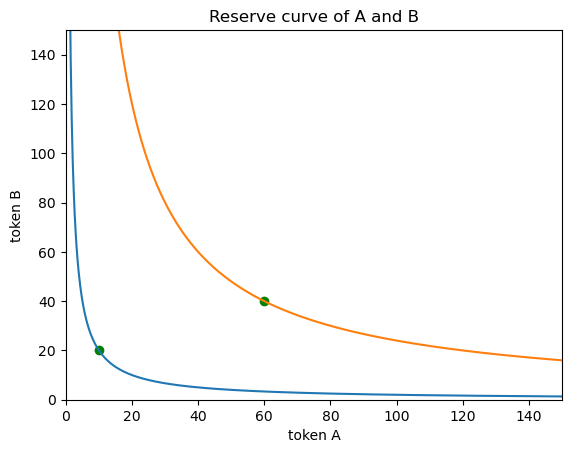

In [95]:

tokens = ['A', 'B']
token_index = {token: i for i, token in enumerate(tokens)}

amms = []
# amms.append(ConstantProductAMM.from_prices([2, 1], 150, [1, 1]))
# amms.append(ConstantProductAMM.from_prices([1, 2, 1], 3000, [1, 1, 1]))
# amms.append(ConstantProductAMM.from_prices([1, 2], 150, [1, 1]))
amms.append(ConstantProductAMM([10, 20]))
amms.append(ConstantProductAMM([60, 40]))
# amms.append(ConstantProductAMM([100, 150]))
# amms.append(ConstantProductAMM([1, 1, 1]))
# amms.append(ConstantSumAMM.from_prices([6, 1, 1], 30))
# amms.append(ConstantSumAMM.from_prices([1, 1, 3, 1, 1], 20))
for amm in amms:
    print(f"reserves: {amm.reserve}, utility: {amm.utility}, gradients: {amm.gradients()}")

reserves, utility = rebalance_n_amms(amms, 1e-3, 5, "A", "B", 150)
# amms[0].plot("A", "B")

reserves before: [22.36067977 44.72135955], [44.72135955 22.36067977]
utilities before: 1000.0000000000001, 1000.0000000000001
new metric before: 14.907119849998598, 14.907119849998598
reserves after: [33.53186863 33.5501707 ], [33.5501707  33.53186863]
utility after: 1124.9999162585916, 1124.9999162585916
utility change: 124.9999162585915, 124.9999162585915
utility pct cg: 12.499991625859147%, 12.499991625859147%
new metrics: 16.77050858290515, 16.77050858290515
convergence in 11917 steps


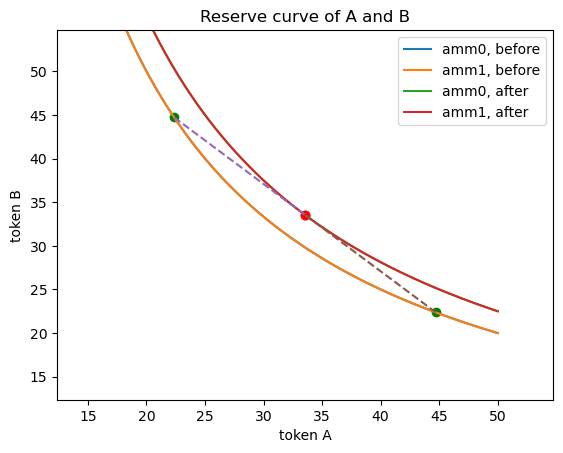

In [69]:

tokens = ['A', 'B']
token_index = {token: i for i, token in enumerate(tokens)}

amms = []
amms.append(ConstantProductAMM.from_prices([2, 1], 1000, [1, 1]))
# amms.append(ConstantProductAMM.from_prices([1, 2, 1], 3000, [1, 1, 1]))
amms.append(ConstantProductAMM.from_prices([1, 2], 1000, [1, 1]))
# amms.append(ConstantSumAMM.from_prices([6, 1, 1], 30))
# amms.append(ConstantSumAMM.from_prices([1, 1, 3, 1, 1], 20))

reserves, utility = rebalance_n_amms(amms, 1e-7, .01, "A", "B", 50)
# amms[0].plot("A", "B")

In [70]:
[amm.price("C", "B") for amm in amms]

KeyError: 'C'

reserves before: [1.57200617 7.86003086 7.86003086 2.62001029 3.93001543], [4.9593442 2.4796721 4.9593442 4.9593442 4.9593442], [4.         4.         1.33333333 4.         4.        ]
utilities before: 999.9999999999984, 1499.9999999999973, 20.0
Exiting: Reserves cannot be negative
reserves after: [5.42759309 6.34657977 2.95379879 5.5935007  5.82890274], [5.10578363 5.69936905 2.62059479 5.26654188 5.47911993], [6.36377294e-06 2.29452192e+00 8.57571634e+00 7.21060516e-01
 1.58270430e+00]
utility after: 3317.404551563825, 2200.5204463410223, 30.325442119948846
utility change: 2317.4045515638263, 700.520446341025, 10.325442119948846
utility pct cg: 231.740455156383%, 46.70136308940176%, 51.62721059974423%
convergence in 1094 steps


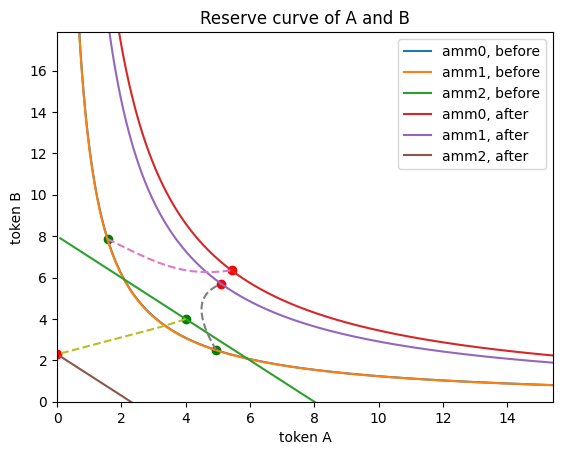

In [ ]:
tokens = ['A', 'B', 'C', 'D', 'E']
token_index = {token: i for i, token in enumerate(tokens)}


amms = []
amms.append(ConstantProductAMM.from_prices([5, 1, 1, 3, 2], 1000, [1, 1, 1, 1, 1]))
amms.append(ConstantProductAMM.from_prices([1, 2, 1, 1, 1], 1500, [1, 1, 1, 1, 1]))
# amms.append(ConstantSumAMM.from_prices([5, 1, 1, 5, 3], 50))
amms.append(ConstantSumAMM.from_prices([1, 1, 3, 1, 1], 20))

reserves, utility = rebalance_n_amms(amms, 1e-6, .01, "A", "B")

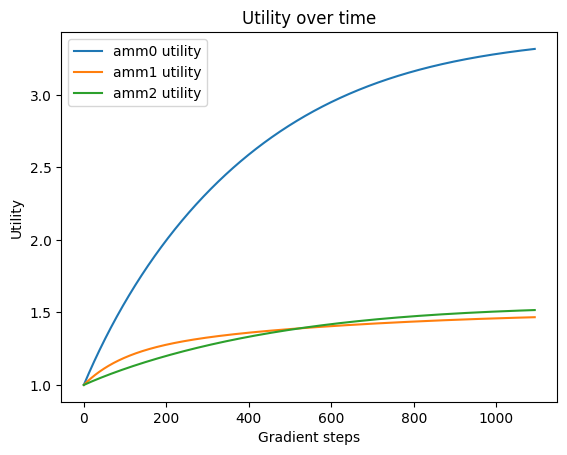

In [ ]:
for i in range(utility.shape[1]):
    plt.plot(np.arange(utility.shape[0]), utility[:, i] / utility[0, i], label=f"amm{i} utility")
plt.xlabel("Gradient steps")
plt.ylabel("Utility")
plt.title("Utility over time")
plt.legend()